In [1]:
import torch.nn as nn
import torch
from torchvision import transforms, datasets, utils
import torch.optim as optim
from torch.utils.data import DataLoader
import json
import time

In [2]:
# 构建网络
class AlexNet(nn.Module):
    # 不需要对卷积核等进行参数初始化，pytorch已经帮我们实现了
    def __init__(self, num_classes=1000, init_weights=False):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            # 有小数但最后一行的padding舍弃掉，纵向或横向只有三层padding
            nn.Conv2d(3, 48, kernel_size=11, stride=4, padding=2),
            # inplace=True会覆盖掉原来的值，降低内存
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(48, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(128, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        self.classifier = nn.Sequential(
            # 默认为0.5
            nn.Dropout(p=0.5),
            nn.Linear(128 * 6 * 6, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, num_classes),
        )
       
            
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x     

In [3]:
# GPU
device = torch.device("cuda:0")

data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
    "val": transforms.Compose([transforms.Resize((224, 224)),  # 必须要(224, 224)不能是224
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
}

train_dataset = datasets.ImageFolder(root = "./DATA/flower_data" + "/train", transform=data_transform["train"])
train_num = len(train_dataset)

# 获得字典
flower_list = train_dataset.class_to_idx
# 将字典的键值反转
cla_dict = dict((val, key) for key ,val in flower_list.items())

# 将文件写入json文件
json_str = json.dumps(cla_dict, indent=4)
with open('class_indices.json', 'w') as json_file:
    json_file.write(json_str)

# 获取数据集
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)

val_dataset = datasets.ImageFolder(root = "./DATA/flower_data" + "/val", transform=data_transform["val"])
val_num = len(val_dataset)
# 可以让batch_size为364一次取完照片
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

In [4]:
net = AlexNet(num_classes=5, init_weights=True)
net = net.to(device)

# 损失函数
loss_function = torch.nn.CrossEntropyLoss()
loss_function = loss_function.to(device)
optimizer = optim.Adam(net.parameters(), lr=0.0002)

# 最佳准确率
best_acc =0.0
# 开始训练
for epoch in range(10):
    # train 考虑到有dropout
    net.train()
    running_loss = 0.0

    for step, data in enumerate(train_loader, start=0):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    # test
    net.eval()
    acc = 0.0
    with torch.no_grad():
        for data_test in val_loader:
            test_images, test_labels = data_test
            test_images = test_images.to(device)
            test_labels = test_labels.to(device)
            
            outputs_1 = net(test_images)
            predict_y = torch.max(outputs_1, dim=1)[1]
            acc += (predict_y == test_labels).sum().item()
        accurate_test = acc / val_num
        if accurate_test > best_acc:
            best_acc = accurate_test
            torch.save(net.state_dict(), "123213")
        print("第{}轮训练的总损失为：{}，准确率为：{}".format(epoch+1, running_loss, accurate_test))

print("finish")

第1轮训练的总损失为：142.8984843492508，准确率为：0.5054945054945055
第2轮训练的总损失为：122.34271723031998，准确率为：0.5851648351648352
第3轮训练的总损失为：112.81791245937347，准确率为：0.5879120879120879
第4轮训练的总损失为：105.08598119020462，准确率为：0.5686813186813187
第5轮训练的总损失为：102.2373508810997，准确率为：0.6428571428571429
第6轮训练的总损失为：96.06958693265915，准确率为：0.5686813186813187
第7轮训练的总损失为：97.39210391044617，准确率为：0.6538461538461539
第8轮训练的总损失为：93.27850413322449，准确率为：0.6840659340659341
第9轮训练的总损失为：89.1948156952858，准确率为：0.7445054945054945
第10轮训练的总损失为：89.6827780008316，准确率为：0.7087912087912088
finish


roses 0.6173503398895264


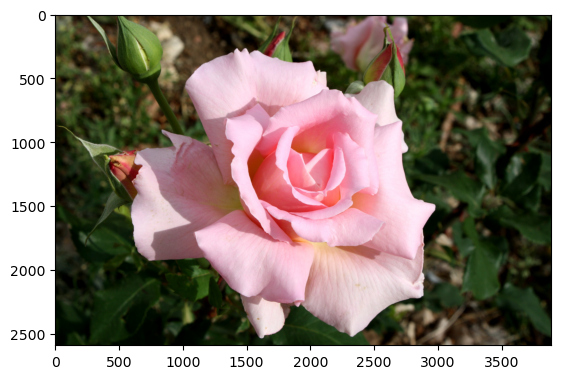

In [18]:
# 开始预测
from PIL import Image
import matplotlib.pyplot as plt
data_transform = transforms.Compose(
    [transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

img = Image.open("./4.jpg")
plt.imshow(img)

img = data_transform(img)
# 添加batch这个维度,为1，不然无法进行计算
img = torch.unsqueeze(img, dim=0)

# 读取json文件获取对应类别
json_file = open("./class_indices.json", 'r')
class_indict =json.load(json_file)

model = AlexNet(num_classes=5, init_weights=True) 
model.load_state_dict(torch.load("./123213"))
model.eval()
with torch.no_grad():
    # 进行压缩，将batch弄掉
    output = torch.squeeze(model(img))
    """
    五种花的概率
    还进行一次softmax的原因是torch.nn.CrossEntropyLoss()虽然自带softmax
    但它只用于求损失上没有对结果直接使用,所以最后的output结果加起来不为1
    可以在下面的单元格看出
    """
    predict = torch.softmax(output, dim=0)  # dim = 0,在列上进行Softmax;dim = 1,在行上进行Softmax，默认dim=1
    # 最高概率的花，再转为numpy
    predict_cla = torch.argmax(predict).numpy()  
print(class_indict[str(predict_cla)], predict[predict_cla].item())
plt.show()

In [13]:
# 添加了batch
img.shape

torch.Size([1, 3, 224, 224])

In [14]:
# 经过softmax为1了
predict

tensor([0.0952, 0.0561, 0.6174, 0.0073, 0.2240])

In [15]:
# 不为1
output

tensor([-0.1148, -0.6427,  1.7552, -2.6770,  0.7415])

In [22]:
print(predict.shape)
print(output.shape)
print(type(predict_cla))
print(predict_cla)
print(predict.shape)

torch.Size([5])
torch.Size([5])
<class 'numpy.ndarray'>
2
torch.Size([5])
